# TP4
### Physique Numérique (PHY-3500)
### Par: Simon Gauthier, Laurent Émond, Thomas Charland
### Présenté à: Xavier Roy-Pomerleau et Antoine Allard
### Remis le: 14 avril 2025

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### TP4.1 Intégration numérique de la dynamique épidémiologique SIS (50 points)

#### a)

On peut simplement solutionner analytiquement l'équation quadratique suivante:
$$
0=(R_0-1)i-R_0i^2
$$
On trouve donc que les solutions, ou états stationnaires, sont:
$$
i^*_1=0\qquad\qquad i^*_2=1-\frac{1}{R_0}
$$
Puisque $i^*_{1,2}$ doit être dans l'intervalle [0,1], cela impose les valeurs $R_0\ge1$.

#### b)

En utilisant $\frac{di}{d\tau}=i'$, on peut placer dans la forme de Bernouilli, soit $i'+p(\tau)i=q(\tau)i^n$:
$$
    i'+(1-R_0)i=(-R_0)i^2
$$
où $p(\tau)=1-R_0$, $q(\tau)=(-R_0)$ et $n=2$.

On peut alors diviser par $i^{-n}=i^{-2}$:
$$
    i^{-2}i'+(1-R_0)i^{-1}=-R_0
$$
On utilise ensuite la substitution $v=i^{1-n}=i^{-1}$. 
$$
    v^2i'+(1-R_0)v=-R_0
$$
On doit également trouver $i'$ en fonction de $v$. On peut dériver implicitement notre substitution et isoler $i'$, soit $i'=-i^2v'=-\frac{1}{v^2}v'$. On remplace:
$$
-v'+(1-R_0)v=-R_0
$$
On divise par $-1$:
$$
v'+(R_0-1)v=R_0
$$
Cette EDO en $v$ est linéaire, on peut donc la résoudre à l'aide de la méthode du facteur d'intégration $\mu(\tau)$. On multiplie donc l'équation par $\mu(\tau)$:
$$
v'\mu(\tau)+(R_0-1)v\mu(\tau)=R_0\mu(\tau)
$$
On assume pour l'instant la condition $\mu(\tau)(R_0-1)=\mu'(\tau)$. On a donc:
$$
v'\mu(\tau)+v\mu'(\tau)=R_0\mu(\tau)
$$
On remarque que le côté gauche est simplement la dérivée du produit $v\mu(\tau)$. On a donc:
$$
(v\mu(\tau))'=R_0\mu(\tau)
$$
On intègre alors des deux côtés par rapport à $\tau$ et on obtient:
$$
v\mu(\tau)+C=\int R_0\mu(\tau) d\tau
$$
où $C$ est notre constante d'intégration. On isole $v$:
$$
v=\frac{\int R_0\mu(\tau) d\tau - C}{\mu(\tau)}
$$
Maintenant, sachant que $\frac{\mu'(\tau)}{\mu(\tau)}=R_0-1$, on trouve que $\mu(\tau)=e^{\int (R_0-1) d\tau + k}=Ke^{(R_0-1)\tau}$ où $K=e^k$ est une constante d'intégration. On a donc:
$$
v=\frac{K\int R_0e^{(R_0-1)\tau} d\tau - \frac{C}{k}}{Ke^{(R_0-1)\tau}}
$$
On définit $c_1=\frac{c}{K}$ pour avoir:
$$
\begin{align*}
v&=\frac{\int R_0e^{(R_0-1)\tau} d\tau - c_1}{e^{(R_0-1)\tau}}\\
&=\frac{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+c_2-c_1}{e^{(R_0-1)\tau}}\\
&=\frac{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+C}{e^{(R_0-1)\tau}}
\end{align*}
$$
où $C=c_2-c_1$ est une constante. On peut alors exprimer $v$ en fonction de $i$ et isoler $i$:
$$
i=\frac{1}{v}=\frac{e^{(R_0-1)\tau}}{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+C}
$$
On peut ensuite utiliser une condition initiale $i(0)=i_0$ pour obtenir:
$$
i_0=\frac{e^{(R_0-1)0}}{\frac{R_0}{R_0-1}e^{(R_0-1)0}+C}=\frac{1}{\frac{R_0}{R_0-1}+C}
$$
On a donc:
$$
C= \frac{R_0-1-R_0i_0}{i_0(R_0-1)}
$$
On a donc:
$$
i(\tau)=\frac{e^{(R_0-1)\tau}}{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+\frac{R_0-1-R_0i_0}{i_0(R_0-1)}}=\frac{i_0(R_0-1)e^{(R_0-1)\tau}}{i_0R_0e^{(R_0-1)\tau}+R_0-1-i_0R_0}
$$
pour $\tau>0$. Cela impose la branche positive de la solution particulière, soit $i>0$.

On peut tracer cette solution pour une condition initiale $i_0=0.5$ et une valeur $R_0=1.5$:

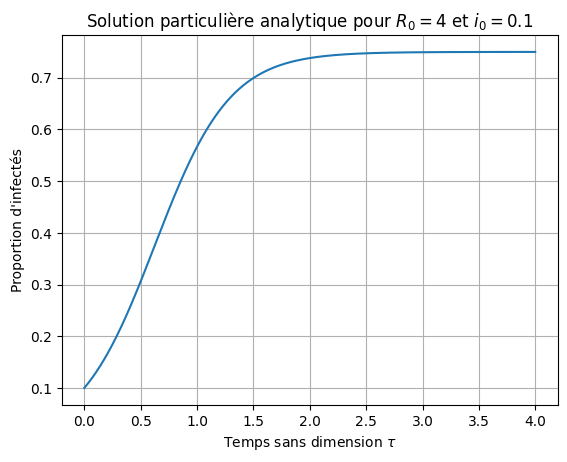

In [86]:
def analytical(times, R0, i0):
    """ Solution particulière analytique du modèle SIR."""
    return (i0*(R0-1)*np.exp((R0-1)*times))/(i0*R0*np.exp((R0-1)*times)+R0-1-i0*R0)


R0 = 4 # nombre de personnes infectées par une personne infectée
i0 = 0.1 # proportion d'infectés au temps t=0

times = np.linspace(0, 4, 1000)

plt.plot(times, analytical(times, R0, i0))
plt.title(fr"Solution particulière analytique pour $R_0={R0}$ et $i_0={i0}$")
plt.xlabel(r"Temps sans dimension $\tau$")
plt.ylabel(r"Proportion d'infectés")
plt.grid()
plt.show()

#### c)
On implémente ici les trois intégrateurs numériques demandés. Ces derniers prennent en entrée une variable $T$, qui détermine le nombre de pas de taille $h$ qui seront faits. Par exemple, pour $T=3$, les deux vecteurs retournées (temps et proportion d'infectés) auront une longueur $T+1$ (puisque les indices débutent à 0). Pour le vecteur de temps, les valeurs choisies seront des multiples de $h$, soit $0, h, 2h, ...$.

In [87]:
def infection_rate(i, R0):
    """Dérivée de la fonction d'infection par rapport au temps dans dimension tau"""
    return (R0-1)*i-R0*i**2

def euler(T, h, R0, i0):
    """ Méthode d'Euler pour la résolution de l'ODE"""
    i = np.zeros(T+1)
    i[0] = i0
    for j in range(1, T+1):
        i[j] = i[j-1] + h*infection_rate(i[j-1], R0)
    return h*np.arange(0, T+1), i

def rk2(T, h, R0, i0):
    """ Méthode de Runge-Kutta d'ordre 2 pour la résolution de l'ODE"""
    i = np.zeros(T+1)
    i[0] = i0
    for j in range(1, T+1):
        k1 = h*infection_rate(i[j-1], R0)
        k2 = h*infection_rate(i[j-1] + 0.5*k1, R0)
        i[j] = i[j-1] + k2
    return h*np.arange(0, T+1), i

def rk4(T, h, R0, i0):
    """ Méthode de Runge-Kutta d'ordre 4 pour la résolution de l'ODE"""
    i = np.zeros(T+1)
    i[0] = i0
    for j in range(1, T+1):
        k1 = h*infection_rate(i[j-1], R0)
        k2 = h*infection_rate(i[j-1] + 0.5*k1, R0)
        k3 = h*infection_rate(i[j-1] + 0.5*k2, R0)
        k4 = h*infection_rate(i[j-1] + k3, R0)
        i[j] = i[j-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    return h*np.arange(0, T+1), i

#### d)
On implémente ici la méthode du ratio dorée pour arriver à isoler une valeur de $h$ pour laquelle la fonction d'erreur donne une valeur entre 0.99$\delta$ et 1.01$\delta$. Puisque la méthode du ratio doré permet de trouver un minimum d'une fonction, et que l'on veut plutôt une valeur d'erreur dans un certain intervalle, il faut ajouter une étape. En effet, lorsque l'on trouve une valeur de $h$ pour laquelle l'erreur est inférieure à 0.99$\delta$, signifiant que nous avons trouvé une solution "trop" précise, une interpolation est faite pour approximer le $h$ qui aurait donné une erreur égale à $\delta$. Puisque l'on sait qu'une relation à peu près linéaire relie les logarithmes de l'erreur et du pas de temps, il est possible d'interpolation linéairement en log-log et de retourner la valeur de $h$ interpolée.

In [88]:
def error(f, T, h, R0, i0):
    times, i = f(T, h, R0, i0)
    i_analytical = analytical(times, R0, i0)
    error = np.sqrt(1/(len(i)+1)*np.sum((i-i_analytical)**2))
    return error

def golden_ratio_method(f, h1, h4, T, R0, i0, delta, max_iter=100):
    z = (1 + np.sqrt(5)) / 2 # nombre d'or
    h2 = h4 - (h4-h1)/z
    h3 = h1 + (h4-h1)/z

    last_h2_log = np.log10(h1)
    last_e2_log = np.log10(error(f, T, h1, R0, i0))

    for i in range(max_iter):
        e2 = error(f, T, h2, R0, i0)
        e3 = error(f, T, h3, R0, i0)
        if i > 0:
            if abs(e2) < 0.99*delta:
                # sachant que log(e) est propotionnel à log(h)
                # on interpole linéaire pour trouver le h pour lequel
                # l'erreur est delta
                h2_log = np.log10(h2)
                e2_log = np.log10(e2)
                log_delta = np.log10(delta)
                
                interp_h2_log = h2_log - (e2_log - log_delta) * (h2_log - last_h2_log) / (e2_log - last_e2_log)
                interp_h2 = 10**interp_h2_log
                return interp_h2
        
        last_h2_log = np.log10(h2)
        last_e2_log = np.log10(e2)
        
        if e2 < e3:
            h4, h3 = h3, h2
            h2 = h4 - (h4-h1)/z

        else:
            h2, h1 = h3, h2
            h3 = h1 + (h4-h1)/z

    raise ValueError("La méthode de la section dorée n'a pas convergé dans le nombre d'itérations maximal autorisé.")

R0/i0,Euler,RK2,RK4
1.5/0.1,1.31e-02 [1.00e-06],2.22e-01 [3.86e-07],7.28e-01 [7.25e-07]
1.5/0.9,8.45e-04 [1.00e-06],9.73e-03 [1.00e-06],1.18e-01 [7.32e-07]
2/0.1,4.98e-03 [1.00e-06],5.51e-02 [9.93e-07],3.09e-01 [8.73e-07]
2/0.9,8.01e-04 [1.00e-06],8.92e-03 [1.00e-06],1.01e-01 [8.03e-07]
3/0.1,2.24e-03 [1.00e-06],2.31e-02 [1.00e-06],1.42e-01 [9.61e-07]
3/0.9,7.49e-04 [1.00e-06],7.88e-03 [1.00e-06],7.78e-02 [8.88e-07]


R0/i0,Euler,RK2,RK4
1.5/0.1,4.13e-03 [1.00e-07],9.95e-02 [8.30e-08],4.59e-01 [8.30e-08]
1.5/0.9,2.67e-04 [1.00e-07],4.47e-03 [1.00e-07],7.25e-02 [8.96e-08]
2/0.1,1.58e-03 [1.00e-07],2.54e-02 [1.00e-07],1.95e-01 [9.45e-08]
2/0.9,2.53e-04 [1.00e-07],4.10e-03 [1.00e-07],6.17e-02 [9.37e-08]
3/0.1,7.08e-04 [1.00e-07],1.07e-02 [1.00e-07],8.97e-02 [9.92e-08]
3/0.9,2.36e-04 [1.00e-07],3.61e-03 [1.00e-07],4.77e-02 [9.80e-08]


R0/i0,Euler,RK2,RK4
1.5/0.1,1.31e-03 [1.00e-08],4.46e-02 [9.91e-09],2.89e-01 [9.05e-09]
1.5/0.9,8.43e-05 [1.00e-08],2.06e-03 [1.00e-08],4.45e-02 [9.87e-09]
2/0.1,4.99e-04 [1.00e-08],1.17e-02 [1.00e-08],1.23e-01 [9.79e-09]
2/0.9,7.99e-05 [1.00e-08],1.89e-03 [1.00e-08],3.79e-02 [1.00e-08]
3/0.1,2.24e-04 [1.00e-08],4.98e-03 [1.00e-08],5.66e-02 [9.99e-09]
3/0.9,7.47e-05 [1.00e-08],1.67e-03 [1.00e-08],2.93e-02 [1.01e-08]


R0/i0,Euler,RK2,RK4
1.5/0.1,4.13e-04 [1.00e-09],2.01e-02 [1.00e-09],1.82e-01 [9.52e-10]
1.5/0.9,2.67e-05 [1.00e-09],9.55e-04 [1.00e-09],2.73e-02 [1.01e-09]
2/0.1,1.58e-04 [1.00e-09],5.44e-03 [1.00e-09],7.73e-02 [9.93e-10]
2/0.9,2.53e-05 [1.00e-09],8.75e-04 [1.00e-09],2.33e-02 [1.00e-09]
3/0.1,7.09e-05 [1.00e-09],2.31e-03 [1.00e-09],3.58e-02 [1.00e-09]
3/0.9,2.36e-05 [1.00e-09],7.71e-04 [1.00e-09],1.81e-02 [1.00e-09]


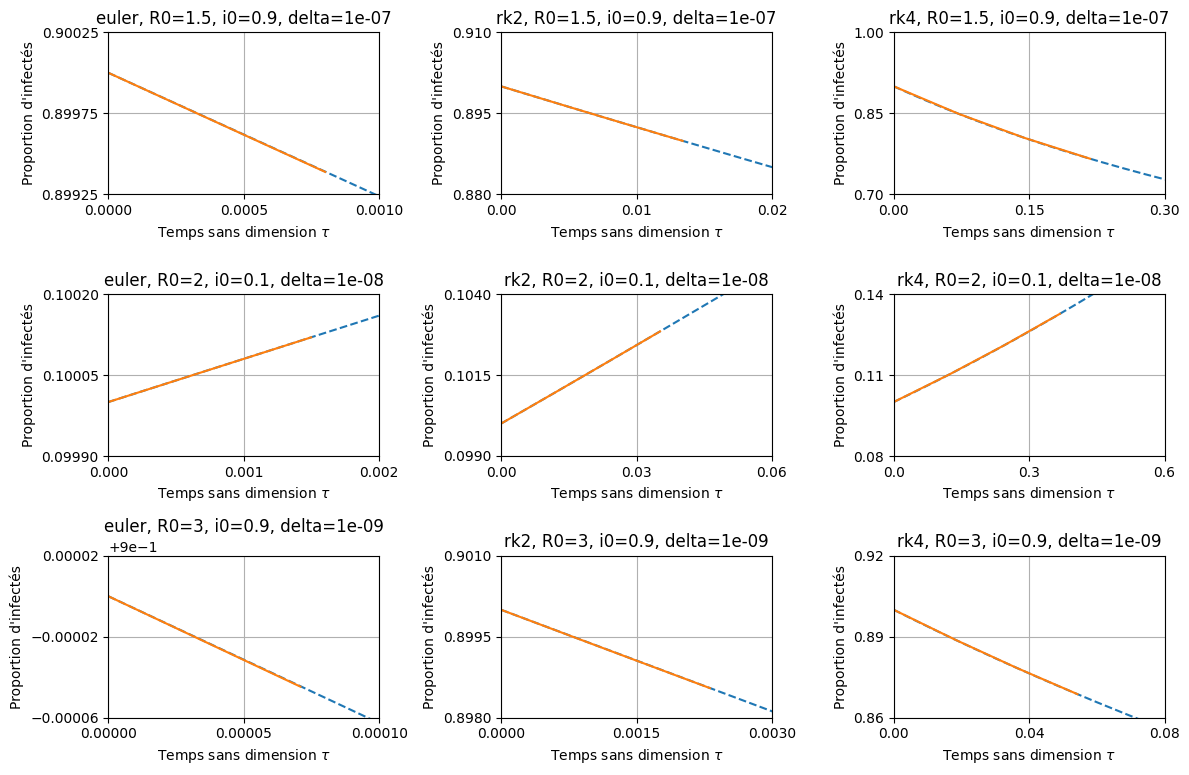

In [110]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.ticker as ticker


R0i0_pairs = [(1.5, 0.1), (1.5, 0.9), (2, 0.1), (2, 0.9), (3, 0.1), (3, 0.9)]
deltas = [1e-6, 1e-7, 1e-8, 1e-9]

delta_R0i0_to_show = [
    (1.5, 0.9, 1e-7),
    (2, 0.1, 1e-8), 
    (3, 0.9, 1e-9),
]

T = 3

plt.figure(figsize=(12, 8))

for delta in deltas:
    results = pd.DataFrame(columns=["R0/i0", "Euler", "RK2", "RK4"])

    for R0, i0 in R0i0_pairs:
        times = np.linspace(0, T, 1000) # finer grid for analytical solution

        delta_R0i0 = (R0, i0, delta)

        methods_results = []

        for j, method in enumerate([euler, rk2, rk4]):
            h1 = 1e-10
            h4 = 0.1

            h = golden_ratio_method(method, h1, h4, T, R0, i0, delta)
            t, i = method(T, h, R0, i0)

            if delta_R0i0 in delta_R0i0_to_show:
                plt.subplot(3, 3, 3*delta_R0i0_to_show.index(delta_R0i0)+j+1)
                plt.xlabel(r"Temps sans dimension $\tau$")
                plt.ylabel(r"Proportion d'infectés")
                plt.grid()
                plt.plot(times, analytical(times, R0, i0), label="Analytique", linestyle='--')
                plt.title(f"{method.__name__}, R0={R0}, i0={i0}, delta={delta}")
                plt.plot(t, i)
                dy = max(i) - min(i)
                y_min = min(i) - 0.2 * dy
                y_max = max(i) + 0.2 * dy
                plt.ylim(y_min, y_max)

                dx = max(t) - min(t)
                x_min = 0
                x_max = max(t) + 0.2 * dx
                plt.xlim(x_min, x_max)

                # Fonction pour créer 3 ticks arrondis
                def round_locator(min_val, max_val):
                    range_val = max_val - min_val
                    step = 10**np.floor(np.log10(range_val))
                    for factor in [1, 2, 2.5, 5]:
                        if range_val / (step * factor) <= 4:
                            step *= factor
                            break
                    tick_min = step * np.floor(min_val / step)
                    tick_max = step * np.ceil(max_val / step)
                    ticks = np.linspace(tick_min, tick_max, 3)
                    return np.round(ticks, 8)

                # Appliquer les ticks personnalisés
                xticks = round_locator(x_min, x_max)
                yticks = round_locator(y_min, y_max)
                plt.xticks(xticks)
                plt.yticks(yticks)

                # Forcer notation décimale normale
                ax = plt.gca()
                ax.ticklabel_format(style='plain', axis='both')  # <- no scientific notation

            error_at_h = error(method, T, h, R0, i0)

            methods_results.append(f"{h:.2e} [{error_at_h:.2e}]")

        results.loc[len(results)] = [f"{R0}/{i0}"] + methods_results


    display(HTML(f"<h2>Valeur de h[erreur] pour delta = {delta}</h2>"))
    # display datafram without index and with borders
    display(HTML(results.to_html(index=False, border=1, justify='center')))

plt.suptitle("")
plt.tight_layout()
plt.show()



On remarque dans les tableaux ci-haut que le comportement est respecté pour la majorité des cas. En effet, on voit que l'erreur (entre crochet) converge dans l'intervalle [0.99, 1.01]$\delta$. On remarque aussi que la grandeur des pas nécessaire pour atteindre cette précision est plus petite pour Euler que pour RK2 et encore plus que pour RK4. On remarque aussi, tel qu'attendu, qu'il faut un pas plus fin pour atteindre une erreur plus petite.

Dans les graphiques, on remarque que les pas choisis permettent de bien suivre la courbe analytique.

#### e)
On simplement créer un espace logarithmique de valeurs de h et calculer l'erreur pour chacun de ces pas de temps. On prend une échelle logarithmique afin de couvrir un plus écart de pas de temps sans devoir choisir énormément de valeurs. 
On peut ensuite tracer en échelle logarithmiques ces valeurs de $h$ et d'erreur associée et prendre la pente d'une régression linéaire de ces points.
Cette pente nous donne la valeur de l'ordre d'erreur $d$ soit 2.00 pour Euler, 3.00 pour RK2 et 5.01 pour RK4.

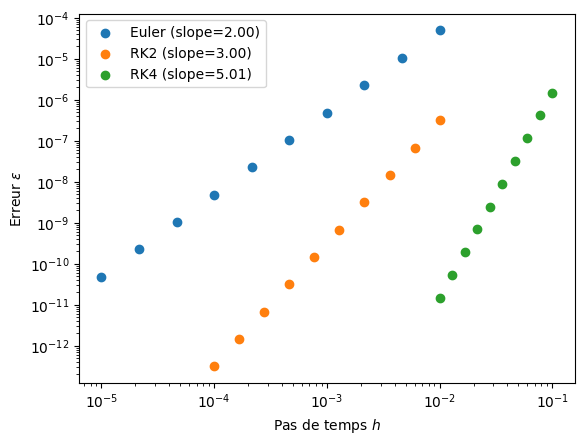

In [122]:
log_h_space_euler = np.logspace(-5, -2, 10)
log_h_space_rk2 = np.logspace(-4, -2, 10)
log_h_space_rk4 = np.logspace(-2, -1, 10)

R0 = 4
i0 = 0.1

errors_euler = np.array([error(euler, T, h, R0, i0) for h in log_h_space_euler]) # erreur pour chacune des valeurs de T
errors_rk2 = np.array([error(rk2, T, h, R0, i0) for h in log_h_space_rk2]) # erreur pour chacune des valeurs de T
errors_rk4 = np.array([error(rk4, T, h, R0, i0) for h in log_h_space_rk4]) # erreur pour chacune des valeurs de T

T = 3

def slope(x, y):
    """ Calcul de la pente d'une régression linéaire """
    return np.polyfit(x, y, 1)[0]

slope_euler = slope(np.log(log_h_space_euler), np.log(errors_euler))
slope_rk2 = slope(np.log(log_h_space_rk2), np.log(errors_rk2))
slope_rk4 = slope(np.log(log_h_space_rk4), np.log(errors_rk4))

plt.scatter(log_h_space_euler, errors_euler, label=f"Euler (slope={slope_euler:.2f})")

plt.scatter(log_h_space_rk2, errors_rk2, label=f"RK2 (slope={slope_rk2:.2f})")
plt.scatter(log_h_space_rk4, errors_rk4, label=f"RK4 (slope={slope_rk4:.2f})")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Pas de temps $h$")
plt.ylabel(r"Erreur $\epsilon$")
plt.legend()
plt.show()

### TP4.2 Simulation Monte-Carlo de la dynamique SIS (50 points)

#### a)


#### b)


#### c)


#### d)